<center>
<h3>Universidade Federal do Rio Grande do Sul (UFRGS)<br>
Programa de Pós-Graduação em Engenharia Civil (PPGEC)<br>
PEC00144 - Métodos Experimentais em Engenharia Civil</h3>

<h1>Trabalho 3A</h1>

<h3>Aluno: <a href="https://github.com/dutitello/">Eduarto Pagnussat Titello</a></h3>

</center>


Este trabalho tem por objetivo: avaliar através de simulações de Monte Carlo a propagação de erro no modelo empregado no trabalho anterior, adotando variáveis Gaussianas. 

In [2]:
# Importando e configurando módulos
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' # Muda backend do jupyter para SVG ;)
import jupyter2latex as j2l # Uma maneira que encontrei para tabelas ficarem ok (github.com/dutitello/Jupyter2Latex)
from numpy import pi
import scipy.stats as st

# Recapitulação do problema adotado

O problema adotado consiste na avaliação das duas primeiras frequências naturais de vibração de um poste em concreto armado, considerando seu comportamento como elástico linear. O poste tem comprimento efetivo $L=12m$, seção constante de diâmetro externo $d_e=50cm$ e espessura $e=6cm$. 

O modelo reduzido empregado para avaliação do problema consiste em um cilindro de alumínio de diâmetro $d_e=6mm$, massa linear $\rho=2700kg/m^3$ e módulo de elastícidade $E=70GPa$. Adotando como escala de comprimento $1:25$ (modelo reduzido tem comprimento $L=48cm$) e através das propriedades do perfil empregado, os três fatores de escala impostos são:

- Comprimento  - $L     = 1:25$

- Massa linear - $\mu_L = 1:2716$

- Rígidez à flexão - $EI    = 1:1.285\times10^7$


Através da análise dimensional realizada anteriormente, o fator de escala de frequências obtido foi $1:0.110$ ou $\lambda_f = 9.085$. 

As frequências naturais de vibração do modelo são dadas por \ref{eq:wn}:

\begin{equation}
f_n = \frac{1}{2\pi} {\Big( \frac{\alpha_n}{L} \Big)}^2 \sqrt{\frac{EI}{\mu_L}}
\label{eq:wn}
\end{equation}

onde, para as duas primeiras frequências naturais, $\alpha_1=1.88$ e $\alpha_2=4.69$, respectivamente. A área da seção transversal circular $A$ e seu momento de inércia $I$ são dados por:

\begin{equation}
A = \frac{\pi d_e^2}{4}
\label{eq:Ac}
\end{equation}

\begin{equation}
I = \frac{\pi d_e^4}{64}
\label{eq:Ic}
\end{equation}

# Propriedades estatísticas do modelo reduzido

Desprezando possíveis erros de matemáticos de modelagem, conforme \ref{eq:wn}, \ref{eq:Ac} e \ref{eq:Ic}, os parâmetros que podem introduzir erros no modelo reduzido são $E$, $d_e$, $\rho$ e $L$. Dado o grande controle tecnológico existente hoje nas industrias, para as propriedades $E$, $d_e$ e $\rho$ são adotados coeficientes de variação de $5\%$, enquanto, para $L$, visto que os perfis devem ser cortados pelo usuário final, é fixado um desvio padrão de $5mm$. Assim, as variáveis aleatórias e suas propriedades são:

| Var. aleatória         | Símbolo | Média ($\mu$) | Coef. de Variação ($CV$) | Desvio Padrão ($\sigma$) |
|------------------------|---------|---------------|--------------------------|--------------------------|
| Módulo de elasticidade | $E$     | 70 GPa        | 5%                       | 3.5 GPa                  |
| Diâmetro externo       | $d_e$   | 6 mm          | 5%                       | 0.3 mm                   |
| Massa específica       | $\rho$  | 2700 kg/m³    | 5%                       | 135 kg/m³                |
| Comprimento            | $L$     | 48 cm         | -                        | 0.5 cm                   |


Com isso as distribuições podem ser construídas no SciPy.

In [3]:
# Módulo de elasticidade em N/m²
mu_E   = 70E9 
std_E  = 0.05*mu_E
rv_E   = st.norm(mu_E, std_E)    

# Diametro do perfil em m
mu_de  = 6/1000
std_de = 0.05*mu_de
rv_de  = st.norm(mu_de, std_de)

# Massa específica em kg/m³
mu_rho  = 2700
std_rho = 0.05*mu_rho
rv_rho  = st.norm(mu_rho, std_rho)

# Comprimento em m
mu_L    = 48/100
std_L   = 0.5/100
rv_L    = st.norm(mu_L, std_L) 

# Função para avaliação do modelo

Para aplicação do método de simulação por Monte Carlo a equação \ref{eq:wn} é introduzida em uma função dependente apenas das variáveis aleatórias de entrada consideradas: 

In [4]:
def frequencias(E, de, rho, L):
    A   = 1/4*pi*de**2 
    I   = 1/64*pi*de**4
    muL = A*rho
    
    # Frequencias naturais do modelo
    fns = 1/(2*pi) * 1/L**2 * (E*I/muL)**0.5
    fn1_m = 1.88**2 * fns
    fn2_m = 4.69**2 * fns
    
    # Frequencias naturais da estrutura
    fn1_e = fn1_m * 1.100726e-01
    fn2_e = fn2_m * 1.100726e-01
    
    return fn1_m, fn2_m, fn1_e, fn2_e

Aplicando sobre a função os valores médios devem ser obtidas as frequências observadas no trabalho anterior:

- Para o modelo reduzido: 18.647 Hz e 116.049 Hz

- Para a estrutura real: 2.053 Hz e 12.774 Hz

In [5]:
freqs = frequencias(mu_E, mu_de, mu_rho, mu_L)
print(freqs)

(18.647119431070642, 116.04909000616033, 2.0525369182884665, 12.773825064612083)


Ok, a função retorna os valores esperados.

# Avaliação da propagação de erro
Para avaliação da propagação de erro, dado o baixo custo computacional do problema, são realizadas $5 \times 10^6$ simulações e os resultados são avaliados cumulativamente, de forma a observar a convergência do processo.

In [6]:
# Controles
N    = int(5E6) # Total de simulações
minp = 10       # Mínimo de pontos para cálcular média e desvio padrão
np.random.seed(666)

# Construção de DataFrame para armazenar os dados
dados = pd.DataFrame()

# Geração de dados aleatórios
dados['E']   = rv_E.rvs(N)
dados['de']  = rv_de.rvs(N)
dados['rho'] = rv_rho.rvs(N)
dados['L']   = rv_L.rvs(N)

# Cálculo das frequencias naturais
dados['fn1_m'], dados['fn2_m'], dados['fn1_e'], dados['fn2_e'] = frequencias(dados['E'].values, dados['de'].values, dados['rho'].values, dados['L'].values)

Uma descrição geral dos dados é apresentada nas Tabelas \ref{tab:descE} e \ref{tab:descf}, onde as médias e o desvios padrões dos paramêtros de entrada convergem para os valores fornecidos, enquanto as médias das frequências naturais apresentam pequenas diferenças em relação aos valores já conhecidos.

In [7]:
pd.set_option('display.float_format', lambda x: f'{x:.3E}')

desc_geral = dados.describe().loc[['mean', 'std', 'min', 'max']]
j2l.df2table(desc_geral[['E', 'de', 'rho', 'L']], 'Descrição geral dos dados de entrada', 'tab:descE')
j2l.df2table(desc_geral[['fn1_m', 'fn2_m', 'fn1_e', 'fn2_e']], 'Descrição geral das frequências naturais', 'tab:descf')

,E,de,rho,L
mean,7.000E+10,6.000E-03,2.700E+03,4.800E-01
std,3.500E+09,2.999E-04,1.350E+02,4.999E-03
min,5.228E+10,4.568E-03,1.985E+03,4.558E-01
max,8.725E+10,7.508E-03,3.394E+03,5.057E-01


,fn1_m,fn2_m,fn1_e,fn2_e
mean,1.867E+01,1.162E+02,2.055E+00,1.279E+01
std,1.209E+00,7.524E+00,1.331E-01,8.282E-01
min,1.306E+01,8.127E+01,1.437E+00,8.946E+00
max,2.573E+01,1.601E+02,2.832E+00,1.763E+01


Nos resultados pode ainda ser observada a linearidade da transformação de escala do modelo, onde:

\begin{equation}
\mu_{f,Est. Real} = \mu_{f, Mod. Red.} \times 1/\lambda_f
\end{equation}

\begin{equation}
\sigma_{f, Est. Real} = \sigma_{f, Mod. Red.} \times 1/\lambda_f
\end{equation}

Dessa forma, as análises a seguir são realizas apenas em relação ao modelo reduzido, objeto principal do estudo.

Através da análise estatística cumulativa dos resultados obtidos pelo método de Monte Carlo a convergência do processo com o aumento do número de simulações pode ser determinada:

In [8]:
roll  = dados[['fn1_m', 'fn2_m']].rolling(N, min_periods=minp)
stds  = roll.std()
means = roll.mean()

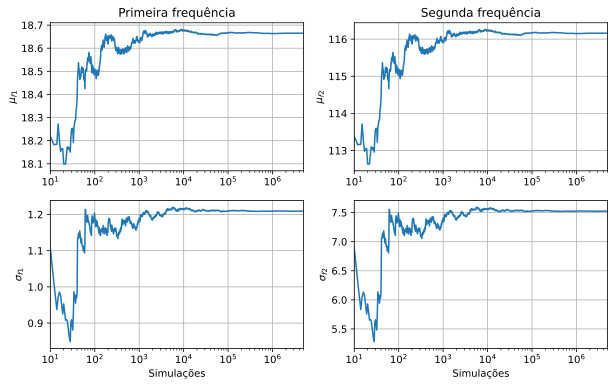

In [9]:
figMeans = plt.figure(1, figsize=(10,6))

pl  = plt.subplot(2,2,1)
means['fn1_m'].plot()
plt.title('Primeira frequência')
plt.ylabel('$\mu_{f1}$')
plt.xscale('log')
plt.xlim(minp,N)
plt.grid(True)

pl  = plt.subplot(2,2,2)
means['fn2_m'].plot()
plt.title('Segunda frequência')
plt.ylabel('$\mu_{f2}$')
plt.xscale('log')
plt.xlim(minp,N)
plt.grid(True)

pl  = plt.subplot(2,2,3)
stds['fn1_m'].plot()
plt.xlabel('Simulações')
plt.ylabel('$\sigma_{f1}$')
plt.xscale('log')
plt.xlim(minp,N)
plt.grid(True)

pl  = plt.subplot(2,2,4)
stds['fn2_m'].plot()
plt.xlabel('Simulações')
plt.ylabel('$\sigma_{f2}$')
plt.xscale('log')
plt.xlim(minp,N)
plt.grid(True)

Conforme a figura, as médias e desvios padrões das frequências de vibração do modelo reduzido estabilizam com cerca de $2\times 10^5$ simulações, sendo esse valor observado para diferentes sementes geradoras de números aleatórios. Dada a convergência do processo os valores apresentados anteriormente, na descrição dos resultados, são adotados, dessa forma:

In [10]:
mean_f1 = desc_geral.loc['mean']['fn1_m']
mean_f2 = desc_geral.loc['mean']['fn2_m']
std_f1  = desc_geral.loc['std']['fn1_m']
std_f2  = desc_geral.loc['std']['fn2_m']


print('''Considerando as incertezas existentes:
 - A primeira frequência de vibração do modelo reduzido é {f1:.2f} Hz com um desvio padrão de {f1s:.2f} Hz
 - A segunda frequência de vibração do modelo reduzido é {f2:.2f} Hz com um desvio padrão de {f2s:.2f} Hz
 '''.format(f1=mean_f1, f2=mean_f2, f1s=std_f1, f2s=std_f2))

Considerando as incertezas existentes:
 - A primeira frequência de vibração do modelo reduzido é 18.67 Hz com um desvio padrão de 1.21 Hz
 - A segunda frequência de vibração do modelo reduzido é 116.16 Hz com um desvio padrão de 7.52 Hz
 


Como a média e o desvio padrão dos resultados são conhecidos os histogramas dos resultados podem ser comparados às distribuições normais formadas por tais parâmetros, avaliando diferentes números de simulações:

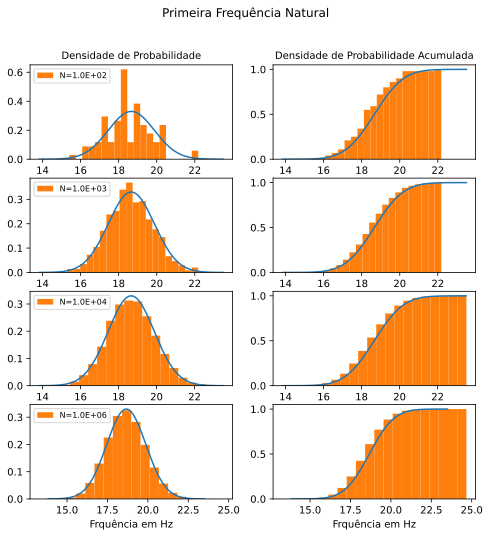

In [11]:
rv_f1 = st.norm(mean_f1, std_f1)
rv_f2 = st.norm(mean_f2, std_f2)

k = 4
x1 = np.linspace(mean_f1 - k*std_f1, mean_f1 + k*std_f1, 500)
x2 = np.linspace(mean_f2 - k*std_f2, mean_f2 + k*std_f2, 500)

Nhs = [100, 1000, 10000, int(1e6)]

figHists = plt.figure(2, figsize=(8,8))
figHists.suptitle('Primeira Frequência Natural')
for i, Nh in enumerate(Nhs):
    pl = plt.subplot(len(Nhs), 2, 2*(i+1)-1)
    if i==0: plt.title('Densidade de Probabilidade', size=10)
    plt.plot(x1, rv_f1.pdf(x1))
    dados['fn1_m'][0:Nh].plot(kind='hist', density=True, bins=20, label=f'N={Nh:.1E}')
    plt.ylabel(None)
    if i+1==len(Nhs): plt.xlabel('Frquência em Hz')
    plt.legend(loc='upper left', fontsize=8)

    pl = plt.subplot(len(Nhs), 2, 2*(i+1))
    if i==0: plt.title('Densidade de Probabilidade Acumulada', size=10)
    plt.plot(x1, rv_f1.cdf(x1))
    dados['fn1_m'][0:Nh].plot(kind='hist', density=True, bins=20, cumulative=True)
    plt.ylabel(None)
    if i+1==len(Nhs): plt.xlabel('Frquência em Hz')

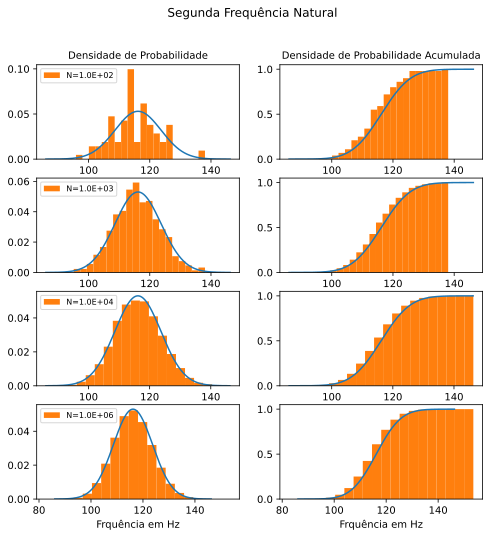

In [12]:
figHists = plt.figure(3, figsize=(8,8))
figHists.suptitle('Segunda Frequência Natural')
for i, Nh in enumerate(Nhs):
    pl = plt.subplot(len(Nhs), 2, 2*(i+1)-1)
    if i==0: plt.title('Densidade de Probabilidade', size=10)
    plt.plot(x2, rv_f2.pdf(x2))
    dados['fn2_m'][0:Nh].plot(kind='hist', density=True, bins=20, label=f'N={Nh:.1E}')
    plt.ylabel(None)
    if i+1==len(Nhs): plt.xlabel('Frquência em Hz')
    plt.legend(loc='upper left', fontsize=8)

    pl = plt.subplot(len(Nhs), 2, 2*(i+1))
    if i==0: plt.title('Densidade de Probabilidade Acumulada', size=10)
    plt.plot(x2, rv_f2.cdf(x2))
    dados['fn2_m'][0:Nh].plot(kind='hist', density=True, bins=20, cumulative=True)
    plt.ylabel(None)
    if i+1==len(Nhs): plt.xlabel('Frquência em Hz')

Conforme esperado, o aumento do número de simulações consideradas na construção dos histogramas melhorou a suavidade desses. Em relação à distribuição dos resultados, mesmo com uma função não-linear é observada boa aderência desses à distribuição normal. 

Sendo o erro propagado uma variável aleatória de distribuição normal, podem ser determinados intervalos de confiança das frequências do modelo reduzido, considerando erros bilaterais, por:

\begin{equation}
\mu_{fi} - k \sigma_{fi} \le f_i \le \mu_{fi} + k \sigma_{fi}
\end{equation}

onde $k$ é obtido através do inverso da distribuição de probabilidade acumulada para um dado erro $\varepsilon$ tal que:

\begin{equation}
k = -\Phi^{-1}(\varepsilon/2)
\end{equation}

Supondo erros bilaterais aceitáveis de 2.5%, 5%, 10% e 50% os limites obtidos são:

In [13]:
def IC(mean, std, err):
    k = -st.norm.ppf(err/2) # Bilateral
    return mean-k*std, mean+k*std, k

def printIC(err):
    f1min, f1max, k = IC(mean_f1, std_f1, err)
    f2min, f2max, k = IC(mean_f2, std_f2, err)
    print(f'''Com uma confiança de {1-err:.2%}: (k={k:.3f})
    * {f1min:.2f} Hz <= f1 <= {f1max:.2f} Hz
    * {f2min:.2f} Hz <= f2 <= {f2max:.2f} Hz
    ''')
    
printIC(0.025)
printIC(0.050)
printIC(0.100)
printIC(0.500)

Com uma confiança de 97.50%: (k=2.241)
    * 15.96 Hz <= f1 <= 21.38 Hz
    * 99.30 Hz <= f2 <= 133.03 Hz
    
Com uma confiança de 95.00%: (k=1.960)
    * 16.30 Hz <= f1 <= 21.03 Hz
    * 101.41 Hz <= f2 <= 130.91 Hz
    
Com uma confiança de 90.00%: (k=1.645)
    * 16.68 Hz <= f1 <= 20.65 Hz
    * 103.78 Hz <= f2 <= 128.54 Hz
    
Com uma confiança de 50.00%: (k=0.674)
    * 17.85 Hz <= f1 <= 19.48 Hz
    * 111.09 Hz <= f2 <= 121.24 Hz
    


Evidentemente, a aceitação de um erro maior reduz o tamanho do intervalo de frequências possíveis. Dos resultados apresentados acima, adotando a confiança de 95%, ou probabilidade do valor estar fora do intervalo de 5%, as frequências do modelo estão nos intervalos:

$$ 16.30 Hz \le f_1 \le 21.03 Hz $$

$$ 101.41 Hz \le f_2 \le 130.91 Hz $$


Os intervalos podem ainda ser ilustrados sobre a curva de densidade de probabilidade das distribuições de frequências:

(0.0, 0.05567011217681224)

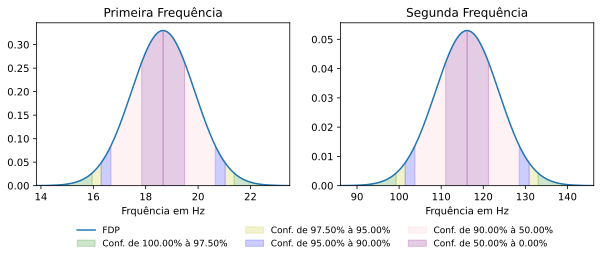

In [14]:
def plotIC(mean, std, err):
    limmin = mean - k*std
    limmax = mean + k*std
    
    ea     = 0
    colors = ['g', 'y', 'b', 'pink', 'purple']
    
    for i, e in enumerate(err):
        fmin, fmax, _ = IC(mean, std, e)
        xa  = np.linspace(limmin, fmin, 100)
        xb  = np.linspace(fmax, limmax, 100)
        
        y1a = np.zeros(xa.shape)
        y1b = np.zeros(xb.shape)
        
        y2a = st.norm.pdf(xa, mean, std)
        y2b = st.norm.pdf(xb, mean, std)
        
        pl.fill_between(xa, y1a, y2a, color=colors[i], alpha=0.2, label=f'Conf. de {1-ea:.2%} à {1-e:.2%}')
        pl.fill_between(xb, y1b, y2b, color=colors[i], alpha=0.2, label=None)
        
        limmin = fmin
        limmax = fmax
        ea     = e
        

figHists = plt.figure(4, figsize=(10,3))

pl = plt.subplot(1, 2, 1)
plt.title('Primeira Frequência')

plt.plot(x1, rv_f1.pdf(x1), label='FDP')
plotIC(mean_f1, std_f1, err=[0.025, 0.050, 0.100, 0.5, 1])

plt.grid(False)
plt.ylabel(None)
plt.xlabel('Frquência em Hz')
plt.xlim(x1.min(), x1.max())
plt.ylim(0)
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(1.1,-0.2), fontsize=9, frameon=False)


pl = plt.subplot(1, 2, 2)
plt.title('Segunda Frequência')

plt.plot(x2, rv_f2.pdf(x2), label='FDP')
plotIC(mean_f2, std_f2, err=[0.025, 0.050, 0.100, 0.5, 1])

plt.grid(False)
plt.ylabel(None)
plt.xlabel('Frquência em Hz')
plt.xlim(x2.min(), x2.max())
plt.ylim(0)

# Considerações finais

A consideração das incertezas intrinsecas dos materiais usados na construção do modelo reduzido tornou seu comportamento também incerto. 
As incertezas existentes nas propriedades dos materiais foram propagadas no modelo através da realização de $N=5\times10^6$ simulações de Monte Carlo e, posteriormente, as $N$ respostas observadas foram caracterizadas através de análises estatísticas. 
Observou-se que ambas as frequências naturais de vibração do modelo reduzido são bem descritas por variáveis de distribuição normal/Gaussiana:


$$ f_1 ~\sim ~N(\mu_{f1}=18.67 Hz; \;\; \sigma_{f1}=1.21 Hz)$$

$$ f_2 ~\sim ~N(\mu_{f2}=116.16 Hz; \; \sigma_{f2}=7.52 Hz)$$

onde as médias das variáveis aleatórias são aproximadamente as frequências obtidas com as propriedades médias dos materiais. 

Conhecidas as distribuições de probabilidade das frequências naturais foram determinados seus intervalos de confiança, onde, com uma confiança de 95%, tem-se que as frequências são:

$$16.30 Hz \le f_1 \le 21.03 Hz$$

$$101.41 Hz \le f_2 \le 130.91 Hz$$
